In [1]:
# Pytorch basic modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

# Data loading and augmentation
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Visualization and math operations
from tqdm.notebook import trange, tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

#### To ensure the reproducibility of experiments, it is essential to control pseudo-random values by setting a fixed seed. This guarantees that the results are consistent across different runs, allowing for accurate comparisons and validation of the experiment.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Preparing the dataset

#### Specifying the dataset location

In [3]:
ROOT = 'data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:03<00:00, 3.12MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 139kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.15MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 2.27MB/s]


#### To simplify and accelerate the training process while making it more reliable by avoiding local minima, it's crucial to calculate the mean and standard deviation of the training set. The test set should remain untouched during training to ensure that no information from it influences the model. The test set should only be used when evaluating the final model performance by calculating the test loss.

In [4]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [5]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


#### To improve the model's performance, it's essential to introduce diversity into the training data. This can be achieved through data augmentation, which can be implemented using the PyTorch `transforms` module. By applying random transformations such as rotations, flips, or changes in scale, the model is exposed to a wider variety of data, helping it generalize better and become more robust.

In [6]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

#### Now, we can load the training and test subsets of the dataset while applying the necessary transformations. It's important to note that once the dataset is downloaded, it will not be downloaded again.

In [7]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


#### We can visualize the dataset before starting the actual work, as understanding the data is crucial for gaining useful insights. Visualizing the dataset allows us to better grasp its structure and characteristics. MNIST is one of the classic example datasets in machine learning, known for being one of the first tasks successfully tackled using artificial neural networks. It consists of handwritten digits, providing a foundational benchmark for developing and testing various machine learning algorithms.

In [9]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

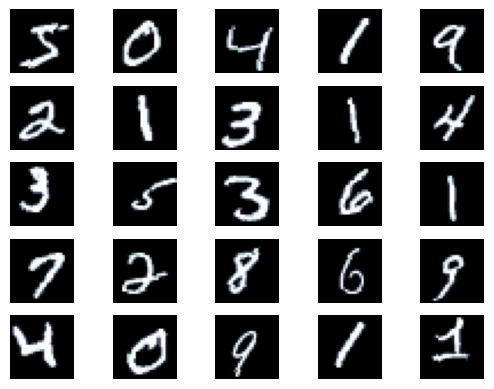

In [10]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

#### The validation dataset plays a crucial role in assessing the model's performance on unseen data during training. It provides valuable insights into how well the model generalizes, helping guide hyperparameter tuning and ensuring the model is not overfitting. It's important to note that the validation dataset must be extracted from the training data. In our example, we allocate 10% of the training data for validation

In [11]:
VALID_RATIO = 0.1               # 10%
TRAIN_RATIO = 1 - VALID_RATIO   # 100% - VALID_RATIO

n_train_examples = int(len(train_data) * TRAIN_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [12]:
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [13]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


#### Validation data is used for performance evaluation, so it should not include any augmentations, similar to the test set. Therefore, we apply the same transformations to the validation subset as we do to the test set.

In [14]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

# Training phase

#### Before training begins, it's essential to define key hyperparameters, such as batch size, and create iterators for each subset of the data. In each iteration of the training loop, these iterators will retrieve a batch of data, which helps to train more efficiently and achive better generalization.

In [15]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

#### Here, we define a simple MLP model that consits of input layer, output layer and one hidden layer of size 512.

In [16]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.output_dim = output_dim

        hidden_layer_dimension = 512

        self.input_layer = nn.Linear(input_dim, hidden_layer_dimension)
        self.hidden_layer = nn.Linear(hidden_layer_dimension, hidden_layer_dimension)
        self.output_layer = nn.Linear(hidden_layer_dimension, output_dim)

    def forward(self, x):

        # x = [batch size (B), height (H), width (W)]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [B, H * W]

        out_1 = F.tanh(self.input_layer(x))

        # out_1 = [B, hidden_layer_dimension (512)]

        out_2 = F.tanh(self.hidden_layer(out_1))

        # out_2 = [B, hidden_layer_dimension (512)]

        prediction = self.output_layer(out_2)

        # prediction = [B, output dim]

        return prediction

#### After declaring the model, we can initialize it.

In [17]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

#### To optimize the model's parameters using gradient descent during each iteration, we use the Adam optimizer.

In [18]:
optimizer = optim.Adam(model.parameters())

#### To estimate the difference between the model's predictions and the actual values, we use a loss function. In our model, we will utilize cross-entropy loss, which is particularly well-suited for classification tasks.

In [19]:
loss_function = nn.CrossEntropyLoss()

#### We need to define the device where our model will be trained, which can either be the CPU or GPU

In [20]:
device = torch.device('cpu')

#### The `to()` method is responsible for transferring the model or data to a specified device, such as a CPU or GPU.

In [21]:
model = model.to(device)
loss_function = loss_function.to(device)

#### We can calculate accuracy by finding the mean of the sum of correct predictions in the training data batch

In [22]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

#### Finally, we define the training and evaluation functions. The key difference is that during evaluation, the model should be set to evaluation mode, and torch.no_grad() should be used. Some layers, such as dropout and batch normalization, behave differently during training and evaluation, so it's important to inform the model that we are in "evaluation" mode. While the model we are using here may not include such layers, it's still good practice to explicitly set the model to training mode during training and evaluation mode during evaluation. The torch.no_grad() context manager ensures that gradients are not calculated for operations inside the block, which makes the evaluation process faster and reduces memory usage, as the model does not need to store intermediate gradients for backpropagation.

In [23]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [24]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### During the training phase, we iterate through the defined number of epochs, training the model in each new iteration. In every epoch, the model is trained on the training data, and at the end of each iteration, we measure the validation loss to evaluate the model's performance on unseen data. We track the validation loss and save the model weights whenever we achieve the best performance, i.e., the lowest validation loss observed so far. This helps us ensure that the model is not overfitting and that we are retaining the best-performing weights for final evaluation.

In [26]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.perf_counter()

    train_loss, train_acc = train(model, train_iterator, optimizer, loss_function, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, loss_function, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'mlp-model-mnist.pt')

    end_time = time.perf_counter()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 18s
	Train Loss: 0.402 | Train Acc: 87.40%
	 Val. Loss: 0.156 |  Val. Acc: 94.97%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 18s
	Train Loss: 0.173 | Train Acc: 94.55%
	 Val. Loss: 0.120 |  Val. Acc: 96.20%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 0.136 | Train Acc: 95.74%
	 Val. Loss: 0.108 |  Val. Acc: 96.58%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 0.126 | Train Acc: 96.06%
	 Val. Loss: 0.090 |  Val. Acc: 97.05%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 19s
	Train Loss: 0.116 | Train Acc: 96.34%
	 Val. Loss: 0.090 |  Val. Acc: 96.97%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 19s
	Train Loss: 0.108 | Train Acc: 96.53%
	 Val. Loss: 0.088 |  Val. Acc: 96.99%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 18s
	Train Loss: 0.101 | Train Acc: 96.76%
	 Val. Loss: 0.076 |  Val. Acc: 97.68%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 18s
	Train Loss: 0.098 | Train Acc: 96.95%
	 Val. Loss: 0.070 |  Val. Acc: 97.73%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 18s
	Train Loss: 0.096 | Train Acc: 96.96%
	 Val. Loss: 0.082 |  Val. Acc: 97.21%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 19s
	Train Loss: 0.092 | Train Acc: 97.13%
	 Val. Loss: 0.073 |  Val. Acc: 97.62%


#### After the training has been completed, we can load the best model (the one with the lowest validation loss) and evaluate its performance on the test dataset. This allows us to assess how well the model generalizes to completely unseen data. Once the model's performance has been evaluated, it can be used for further applications, such as inference on new data, deployment in a real-world environment, or integration into a larger system. By using the best-performing model, we ensure that the predictions are as accurate as possible based on the trained parameters.

In [27]:
model.load_state_dict(torch.load('mlp-model-mnist.pt', weights_only=True))

test_loss, test_acc = evaluate(model, test_iterator, loss_function, device)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

In [28]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.066 | Test Acc: 97.87%


# Inspecting the model deeper

In [29]:
def plot_weights(weights, n_weights):

    rows = int(np.sqrt(n_weights))
    cols = int(np.sqrt(n_weights))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(weights[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

##### We can visualize the learned weights of the model, to gain insights into what the model has learned during training. For example, in the case of a model trained for digit recognition on the MNIST dataset, the first layers typically learn basic features such as edges, curves, and shapes that are common across digits.

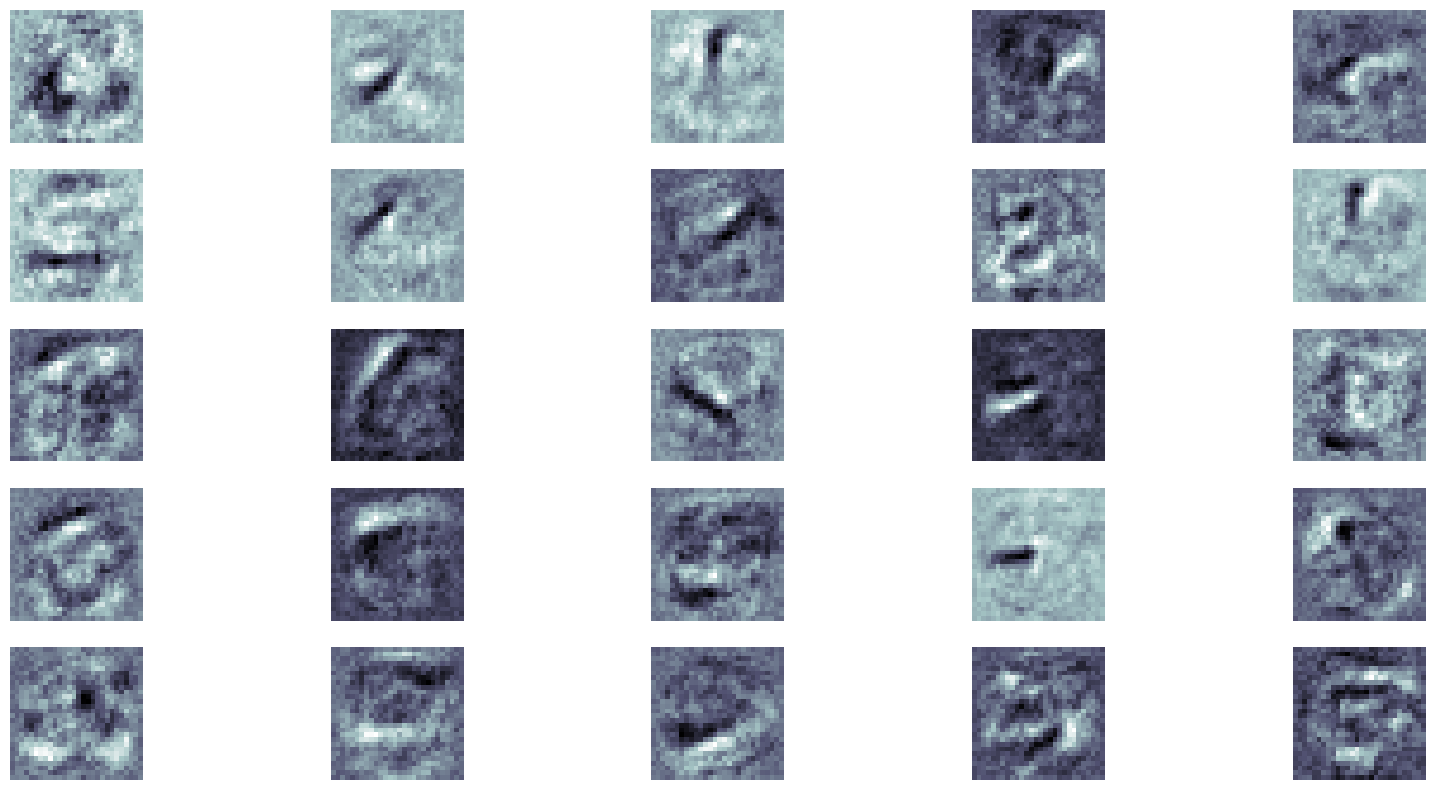

In [30]:
N_WEIGHTS = 25

weights = model.input_layer.weight.data

plot_weights(weights, N_WEIGHTS)

#### Further, we can calculate the number of learnable parameters in our model to understand its complexity and resource requirements

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [33]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 669,706 trainable parameters


#### To understand the data that causes difficulties for the model, we can plot a confusion matrix. A confusion matrix displays the number of correct predictions and misclassifications in a square matrix form, where each row represents the actual class, and each column represents the predicted class. The diagonal elements of the matrix show the correct predictions, while the off-diagonal elements represent misclassifications.

In [34]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [35]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

In [36]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

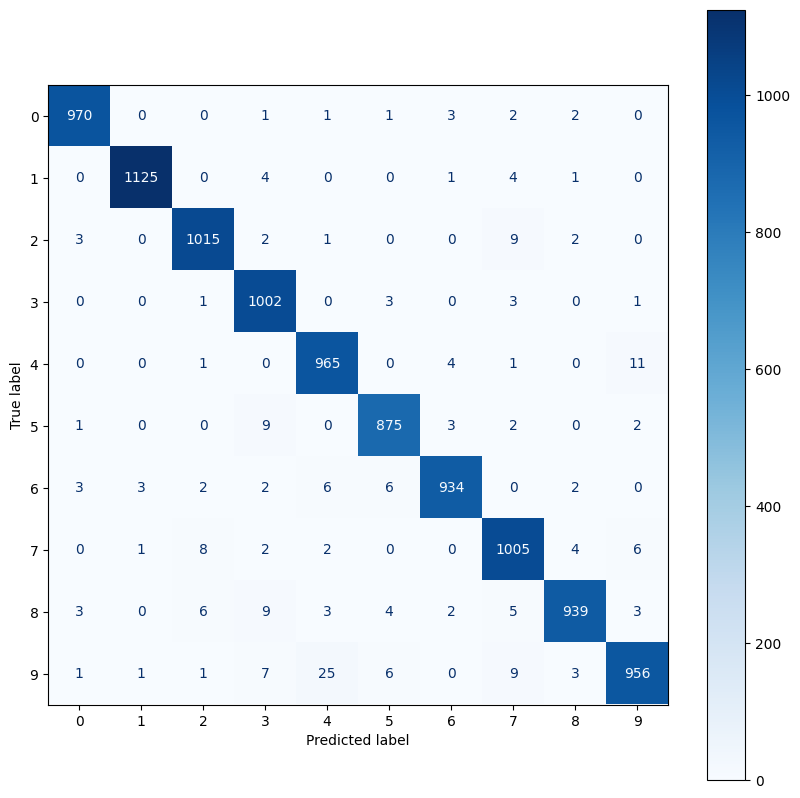

In [37]:
plot_confusion_matrix(labels, pred_labels)

#### Finally, we can display the data that the model failed to classify correctly.

In [38]:
corrects = torch.eq(labels, pred_labels)

In [39]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [40]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'True label: {true_label} ({true_prob:.3f})\n'
                     f'Prediction: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

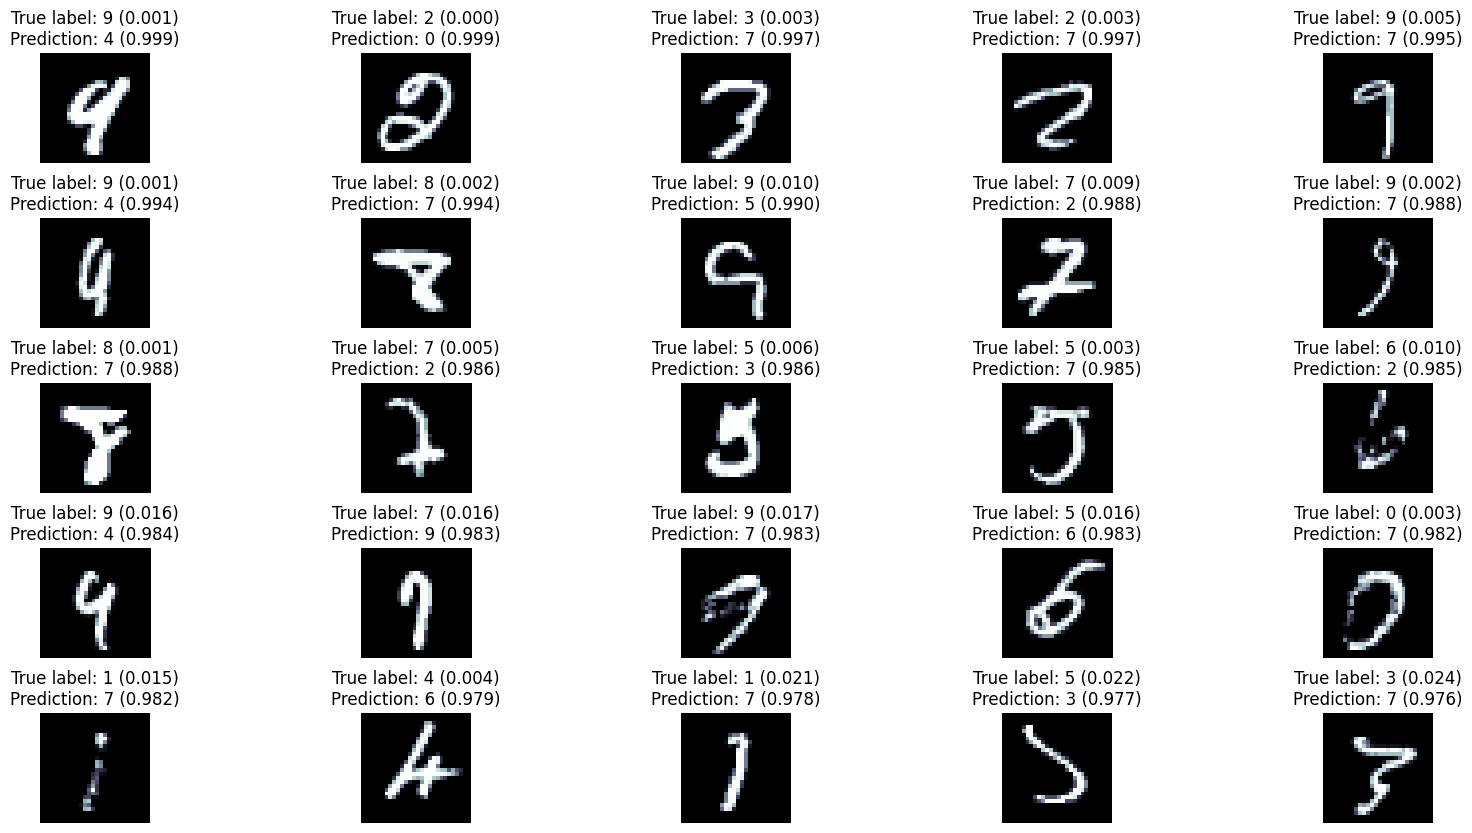

In [41]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)